<a href="https://colab.research.google.com/github/Maelaf/Swahili-Speech-To-Text/blob/main/Speech_recognition_fulltrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("drive/MyDrive/Amharic")
os.listdir()

['valid',
 'src',
 'train',
 'trsTest.txt',
 'valid_corpus.json',
 'train_corpus.json',
 'models',
 'valid.json',
 'test.json',
 'test']

In [ ]:
!pip install python_speech_features

In [ ]:
!pip install mlflow

     |████████████████████████████████| 14.4 MB 59 kB/s 
     |████████████████████████████████| 146 kB 64.0 MB/s 
     |████████████████████████████████| 1.1 MB 48.9 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 79 kB 9.3 MB/s 
     |████████████████████████████████| 636 kB 51.8 MB/s 
     |████████████████████████████████| 170 kB 72.1 MB/s 
     |████████████████████████████████| 75 kB 5.1 MB/s 
     |████████████████████████████████| 68 kB 7.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158170 sha256=98fabbdca0fa08d148bda9ad184a18d25e260f01b7ee44478b8b81a2fca202a0
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.14.3-py3-none-any.whl size=100557 sha256=4a01a98433f3f235af7d28ac66f306d1ce623cd297b2814be4cb211490456355

In [ ]:
import numpy as np
import soundfile
import json

import random
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)
from keras.utils.vis_utils import plot_model


import _pickle as pickle
from numpy.lib.stride_tricks import as_strided

from keras.layers import (Input, Lambda)
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint   
import os

###Utility functions

In [ ]:
supported = """
ሀ ሁ ሂ ሄ ህ ሆ
ለ ሉ ሊ ላ ሌ ል ሎ ሏ
መ ሙ ሚ ማ ሜ ም ሞ ሟ
ረ ሩ ሪ ራ ሬ ር ሮ ሯ
ሰ ሱ ሲ ሳ ሴ ስ ሶ ሷ
ሸ ሹ ሺ ሻ ሼ ሽ ሾ ሿ
ቀ ቁ ቂ ቃ ቄ ቅ ቆ ቋ
በ ቡ ቢ ባ ቤ ብ ቦ ቧ
ቨ ቩ ቪ ቫ ቬ ቭ ቮ ቯ
ተ ቱ ቲ ታ ቴ ት ቶ ቷ
ቸ ቹ ቺ ቻ ቼ ች ቾ ቿ
ኋ
ነ ኑ ኒ ና ኔ ን ኖ ኗ
ኘ ኙ ኚ ኛ ኜ ኝ ኞ ኟ
አ ኡ ኢ ኤ እ ኦ
ኧ
ከ ኩ ኪ ካ ኬ ክ ኮ
ኳ
ወ ዉ ዊ ዋ ዌ ው ዎ
ዘ ዙ ዚ ዛ ዜ ዝ ዞ ዟ
ዠ ዡ ዢ ዣ ዤ ዥ ዦ ዧ
የ ዩ ዪ ያ ዬ ይ ዮ
ደ ዱ ዲ ዳ ዴ ድ ዶ ዷ
ጀ ጁ ጂ ጃ ጄ ጅ ጆ ጇ
ገ ጉ ጊ ጋ ጌ ግ ጐ ጓ ጔ
ጠ ጡ ጢ ጣ ጤ ጥ ጦ ጧ
ጨ ጩ ጪ ጫ ጬ ጭ ጮ ጯ
ጰ ጱ ጲ ጳ ጴ ጵ ጶ ጷ
ፀ ፁ ፂ ፃ ፄ ፅ ፆ ፇ
ፈ ፉ ፊ ፋ ፌ ፍ ፎ ፏ
ፐ ፑ ፒ ፓ ፔ ፕ ፖ
""".split()

char_map = {}
char_map[""] = 0
char_map["<SPACE>"] = 1
index = 2
for c in supported:
    char_map[c] = index
    index += 1
index_map = {v+1: k for k, v in char_map.items()}

In [ ]:
def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

In [ ]:
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs









In [ ]:
def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
    """ Calculate the log of linear spectrogram from FFT energy
    Params:
        filename (str): Path to the audio file
        step (int): Step size in milliseconds between windows
        window (int): FFT window size in milliseconds
        max_freq (int): Only FFT bins corresponding to frequencies between
            [0, max_freq] are returned
        eps (float): Small value to ensure numerical stability (for ln(x))
    """
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq must not be greater than half of "
                             " sample rate")
        if step > window:
            raise ValueError("step size must not be greater than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
    return np.transpose(np.log(pxx[:ind, :] + eps))

In [ ]:
def text_to_int_sequence(text):
    """ Convert text to an integer sequence """
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            # print("checking character " + c + " in map:")
            # print(char_map)
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

In [ ]:
def int_sequence_to_text(int_sequence):
    """ Convert an integer sequence to text """
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text

In [ ]:
# Code adapted from https://martin-thoma.com/word-error-rate-calculation/
def wer(r, h):
    """
    Calculation of WER with Levenshtein distance.

    Works only for iterables up to 254 elements (uint8).
    O(nm) time ans space complexity.

    Parameters
    ----------
    r : list
    h : list

    Returns
    -------
    int

    Examples
    --------
    >>> wer("who is there".split(), "is there".split())
    1
    >>> wer("who is there".split(), "".split())
    3
    >>> wer("".split(), "who is there".split())
    3
    """
    # initialisation
    import numpy
    d = numpy.zeros((len(r)+1)*(len(h)+1), dtype=numpy.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)]

In [ ]:
"""
Helper functions for plotting
"""

import pickle
import matplotlib.pyplot as plt

def plot_hist(p):
    hist = pickle.load(open( "models/" + p + ".pickle", "rb"))
    plt.plot(hist['loss'], label="train")
    plt.plot(hist['val_loss'], label="valid")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show

###Input data generation

In [ ]:

RNG_SEED = 123

def make_audio_gen(train_json,
                   valid_json,
                   minibatch_size=20,
                   spectrogram=True,
                   mfcc_dim=13,
                   sort_by_duration=False,
                   max_duration=10.0):
    return AudioGenerator(train_json, valid_json, minibatch_size=minibatch_size, 
        spectrogram=spectrogram, mfcc_dim=mfcc_dim, max_duration=max_duration,
        sort_by_duration=sort_by_duration)


In [ ]:
"""
Defines a class that is used to featurize audio clips, and provide
them to the network for training or testing.
"""
class AudioGenerator():
    def __init__(self, train_corpus, valid_corpus, step=10, window=20, max_freq=8000, mfcc_dim=13,
        minibatch_size=20, desc_file=None, spectrogram=True, max_duration=10.0, 
        sort_by_duration=False):
        """
        Params:
            step (int): Step size in milliseconds between windows (for spectrogram ONLY)
            window (int): FFT window size in milliseconds (for spectrogram ONLY)
            max_freq (int): Only FFT bins corresponding to frequencies between
                [0, max_freq] are returned (for spectrogram ONLY)
            desc_file (str, optional): Path to a JSON-line file that contains
                labels and paths to the audio files. If this is None, then
                load metadata right away
        """
        self.train_corpus = train_corpus
        self.valid_corpus = valid_corpus
        self.feat_dim = calc_feat_dim(window, max_freq)
        self.mfcc_dim = mfcc_dim
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        self.rng = random.Random(RNG_SEED)
        if desc_file is not None:
            self.load_metadata_from_desc_file(desc_file)
        self.step = step
        self.window = window
        self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size
        self.spectrogram = spectrogram
        self.sort_by_duration = sort_by_duration

    def get_batch(self, partition):
        """ Obtain a batch of train, validation, or test data
        """
        if partition == 'train':
            audio_paths = self.train_audio_paths
            cur_index = self.cur_train_index
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            cur_index = self.cur_valid_index
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            cur_index = self.test_valid_index
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

        features = [self.normalize(self.featurize(a)) for a in 
            audio_paths[cur_index:cur_index+self.minibatch_size]]

        # calculate necessary sizes
        max_length = max([features[i].shape[0] 
            for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, self.minibatch_size)])
        
        # initialize the arrays
        X_data = np.zeros([self.minibatch_size, max_length, 
            self.feat_dim*self.spectrogram + self.mfcc_dim*(not self.spectrogram)])
        labels = np.ones([self.minibatch_size, max_string_length]) * 28
        input_length = np.zeros([self.minibatch_size, 1])
        label_length = np.zeros([self.minibatch_size, 1])
        
        for i in range(0, self.minibatch_size):
            # calculate X_data & input_length
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            # calculate labels & label_length
            label = np.array(text_to_int_sequence(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)
 
        # return the arrays
        outputs = {'ctc': np.zeros([self.minibatch_size])}
        inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
        return (inputs, outputs)

    def shuffle_data_by_partition(self, partition):
        """ Shuffle the training or validation data
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = shuffle_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
            self.train_length = len(self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = shuffle_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
            self.valid_length = len(self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def sort_data_by_duration(self, partition):
        """ Sort the training or validation sets by (increasing) duration
        """
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = sort_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = sort_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def next_train(self):
        """ Obtain a batch of training data
        """
        while True:
            ret = self.get_batch('train')
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
                self.cur_train_index = 0
                self.shuffle_data_by_partition('train')
            yield ret    

    def next_valid(self):
        """ Obtain a batch of validation data
        """
        while True:
            ret = self.get_batch('valid')
            self.cur_valid_index += self.minibatch_size
            if self.cur_valid_index >= len(self.valid_texts) - self.minibatch_size:
                self.cur_valid_index = 0
                self.shuffle_data_by_partition('valid')
            yield ret

    def next_test(self):
        """ Obtain a batch of test data
        """
        while True:
            ret = self.get_batch('test')
            self.cur_test_index += self.minibatch_size
            if self.cur_test_index >= len(self.test_texts) - self.minibatch_size:
                self.cur_test_index = 0
            yield ret

    def load_train_data(self):
        desc_file=self.train_corpus
        self.load_metadata_from_desc_file(desc_file, 'train')
        self.fit_train()
        if self.sort_by_duration:
            self.sort_data_by_duration('train')

    def load_validation_data(self):
        desc_file=self.valid_corpus
        self.load_metadata_from_desc_file(desc_file, 'validation')
        if self.sort_by_duration:
            self.sort_data_by_duration('valid')

    def load_test_data(self):
        desc_file='test_corpus.json'
        self.load_metadata_from_desc_file(desc_file, 'test')
    
    def load_metadata_from_desc_file(self, desc_file, partition):
        """ Read metadata from a JSON-line file
            (possibly takes long, depending on the filesize)
        Params:
            desc_file (str):  Path to a JSON-line file that contains labels and
                paths to the audio files
            partition (str): One of 'train', 'validation' or 'test'
        """
        audio_paths, durations, texts = [], [], []
        with open(desc_file, encoding='utf-8') as json_line_file:
            for line_num, json_line in enumerate(json_line_file):
                try:
                    spec = json.loads(json_line)
                    if float(spec['duration']) > self.max_duration:
                        continue
                    audio_paths.append(spec['key'])
                    durations.append(float(spec['duration']))
                    texts.append(spec['text'])
                except Exception as e:
                    # Change to (KeyError, ValueError) or
                    # (KeyError,json.decoder.JSONDecodeError), depending on
                    # json module version
                    print('Error reading line #{}: {}'
                                .format(line_num, json_line))
        if partition == 'train':
            self.train_audio_paths = audio_paths
            self.train_durations = durations
            self.train_texts = texts
        elif partition == 'validation':
            self.valid_audio_paths = audio_paths
            self.valid_durations = durations
            self.valid_texts = texts
        elif partition == 'test':
            self.test_audio_paths = audio_paths
            self.test_durations = durations
            self.test_texts = texts
        else:
            raise Exception("Invalid partition to load metadata. "
             "Must be train/validation/test")
            
    def fit_train(self, k_samples=100):
        """ Estimate the mean and std of the features from the training set
        Params:
            k_samples (int): Use this number of samples for estimation
        """
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.featurize(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
        
    def featurize(self, audio_clip):
        """ For a given audio clip, calculate the corresponding feature
        Params:
            audio_clip (str): Path to the audio clip
        """
        if self.spectrogram:
            return spectrogram_from_file(
                audio_clip, step=self.step, window=self.window,
                max_freq=self.max_freq)
        else:
            (rate, sig) = wav.read(audio_clip)
            return mfcc(sig, rate, numcep=self.mfcc_dim)

    def normalize(self, feature, eps=1e-14):
        """ Center a feature using the mean and std
        Params:
            feature (numpy.ndarray): Feature to normalize
        """
        return (feature - self.feats_mean) / (self.feats_std + eps)

    def train_length(self):
        return len(self.train_texts)
    
    def valid_length(self):
        return len(self.valid_texts)


def shuffle_data(audio_paths, durations, texts):
    """ Shuffle the data (called after making a complete pass through 
        training or validation data during the training process)
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.random.permutation(len(audio_paths))
    audio_paths = [audio_paths[i] for i in p] 
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def sort_data(audio_paths, durations, texts):
    """ Sort the data by duration 
    Params:
        audio_paths (list): Paths to audio clips
        durations (list): Durations of utterances for each audio clip
        texts (list): Sentences uttered in each audio clip
    """
    p = np.argsort(durations).tolist()
    audio_paths = [audio_paths[i] for i in p]
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def vis_train_features(index=0):
    """ Visualizing the data point in the training set at the supplied index
    """
    # obtain spectrogram
    audio_gen = AudioGenerator(spectrogram=True)
    audio_gen.load_train_data()
    vis_audio_path = audio_gen.train_audio_paths[index]
    vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # obtain mfcc
    audio_gen = AudioGenerator(spectrogram=False)
    audio_gen.load_train_data()
    vis_mfcc_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # obtain text label
    vis_text = audio_gen.train_texts[index]
    # obtain raw audio
    vis_raw_audio, _ = librosa.load(amharic_path(vis_audio_path))
    # print total number of training examples
    print('There are %d total training examples.' % len(audio_gen.train_audio_paths))
    # return labels for plotting
    return vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path


def plot_raw_audio(vis_raw_audio, title='Audio Signal', size=(12, 3)):
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)
    steps = len(vis_raw_audio)
    ax.plot(np.linspace(1, steps, steps), vis_raw_audio)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def plot_mfcc_feature(vis_mfcc_feature):
    # plot the MFCC feature
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_mfcc_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()

def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

###Model defination 

In [ ]:
def model_1(input_dim, units, activation, output_dim=29):
    """ Build a recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add recurrent layer
    simp_rnn = GRU(units, activation=activation,
        return_sequences=True, implementation=2, name='rnn')(input_data)
    # TODO: Add batch normalization 
    bn_rnn = BatchNormalization()(simp_rnn)
    # TODO: Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    plot_model(model, to_file='models/model_1.png')
    return model

###Training 

In [ ]:

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths, label_lengths], 
        outputs=loss_out)
    return model



In [ ]:
def train(audio_gen,
          input_to_softmax, 
          model_name,
          minibatch_size=20,
          optimizer=SGD(learning_rate=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
          epochs=20,
          verbose=1):    
    # calculate steps_per_epoch
    num_train_examples=len(audio_gen.train_audio_paths)
    steps_per_epoch = num_train_examples//minibatch_size
    # calculate validation_steps
    num_valid_samples = len(audio_gen.valid_audio_paths) 
    validation_steps = num_valid_samples//minibatch_size
    
    # add CTC loss to the NN specified in input_to_softmax
    model = add_ctc_loss(input_to_softmax)

    # CTC loss is implemented elsewhere, so use a dummy lambda function for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

    # make results/ directory, if necessary
    if not os.path.exists('models'):
        os.makedirs('models')

    # add checkpointer
    checkpointer = ModelCheckpoint(filepath='models/'+model_name+'.h5', verbose=0)

    # train the model
    hist = model.fit_generator(generator=audio_gen.next_train(), steps_per_epoch=steps_per_epoch,
        epochs=epochs, validation_data=audio_gen.next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer], verbose=verbose, use_multiprocessing=True)

    # save model loss
    with open('models/'+model_name+'.pickle', 'wb') as f:
        pickle.dump(hist.history, f)

###Training RNN model 





In [ ]:
TRAIN_CORPUS = "train_corpus.json"
VALID_CORPUS = "valid_corpus.json"

MFCC_DIM = 13
SPECTOGRAM = False
EPOCHS = 5
MODEL_NAME = "RNN_model"

################ Reminder MINI_BATCH_SIZE=250 
MINI_BATCH_SIZE = 250

SORT_BY_DURATION=False
MAX_DURATION = 10.0

audio_gen = make_audio_gen(TRAIN_CORPUS, VALID_CORPUS, spectrogram=False, mfcc_dim=MFCC_DIM,
                           minibatch_size=MINI_BATCH_SIZE, sort_by_duration=SORT_BY_DURATION,
                           max_duration=MAX_DURATION)
# add the training data to the generator
audio_gen.load_train_data()
audio_gen.load_validation_data()

In [ ]:
model = model_1(input_dim=13,
                units=5,
                activation='relu',
                output_dim=len(char_map)+1)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
rnn (GRU)                    (None, None, 5)           300       
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 5)           20        
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 223)         1338      
_________________________________________________________________
softmax (Activation)         (None, None, 223)         0         
Total params: 1,658
Trainable params: 1,648
Non-trainable params: 10
_________________________________________________________________
None


In [ ]:

train(audio_gen, input_to_softmax=model, model_name=MODEL_NAME, epochs=EPOCHS, minibatch_size=MINI_BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
37/37 [==============================] - 321s 9s/step - loss: 1079.9997 - val_loss: 296.9860
Epoch 2/5
37/37 [==============================] - 364s 10s/step - loss: 189.9148 - val_loss: 229.7775
Epoch 3/5
37/37 [==============================] - 356s 10s/step - loss: 185.1066 - val_loss: 227.6811
Epoch 4/5
37/37 [==============================] - 362s 10s/step - loss: 182.7528 - val_loss: 216.8543
Epoch 5/5
37/37 [==============================] - 369s 10s/step - loss: 181.6490 - val_loss: 220.8959


###Prediciton

In [ ]:
def predict(data_gen, index, partition, model, verbose=True):
    """ Print a model's decoded predictions
    Params:
        data_gen: Data to run prediction on
        index (int): Example to visualize
        partition (str): Either 'train' or 'validation'
        model (Model): The acoustic model
    """
    audio_path,data_point,transcr,prediction = predict_raw(data_gen, index, partition, model)
    output_length = [model.output_length(data_point.shape[0])]
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length, greedy=False)[0][0])+1).flatten().tolist()
    predicted = ''.join(int_sequence_to_text(pred_ints)).replace("<SPACE>", " ")
    wer_val = wer(transcr, predicted)
    if verbose:
        display(Audio(audio_path, embed=True))
        print('Truth: ' + transcr)
        print('Predicted: ' + predicted)
        print("wer: %d" % wer_val)
    return wer_val

In [ ]:
def predict_raw(data_gen, index, partition, model):
    """ Get a model's decoded predictions
    Params:
        data_gen: Data to run prediction on
        index (int): Example to visualize
        partition (str): Either 'train' or 'validation'
        model (Model): The acoustic model
    """

    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    prediction = model.predict(np.expand_dims(data_point, axis=0))
    return (audio_path,data_point,transcr,prediction)



In [ ]:
def calculate_wer(model, model_name, data_gen, partition, length):
    start = time.time()
    def wer_single(i):
        wer = predict(data_gen, i, partition, model, verbose=False)
        if (i%100==0) and i>0:
            print("processed %d in %d minutes" % (i, ((time.time() - start)/60)))
        return wer
    wer = list(map(lambda i: wer_single(i), range(1, length)))
    print("Total time: %f minutes" % ((time.time() - start)/60))
    filename = 'models/' + model_name + '_' + partition + '_wer.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(wer, handle)
    return wer




In [ ]:
def load_wer(model_name, partition):
    filename = 'models/' + model_name + '_' + partition + '_wer.pickle'
    return pickle.load(open(filename, "rb"))

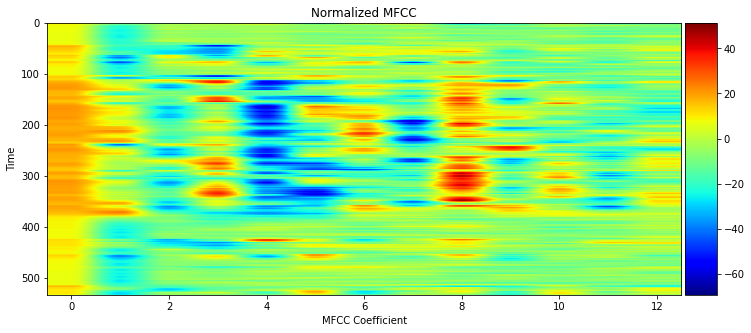

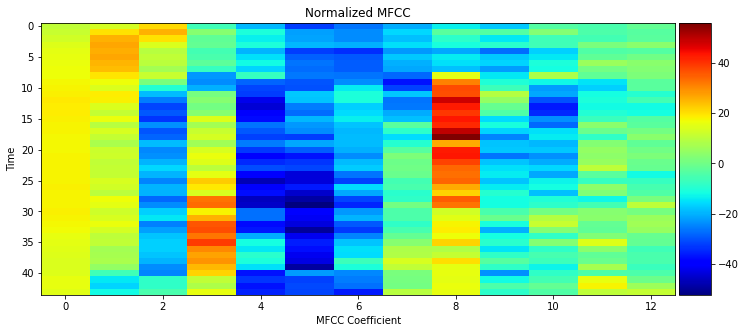

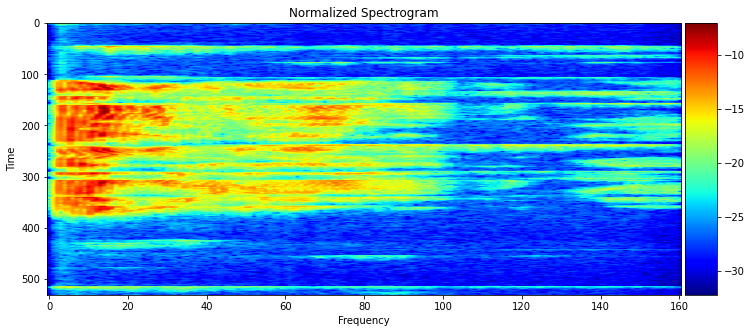

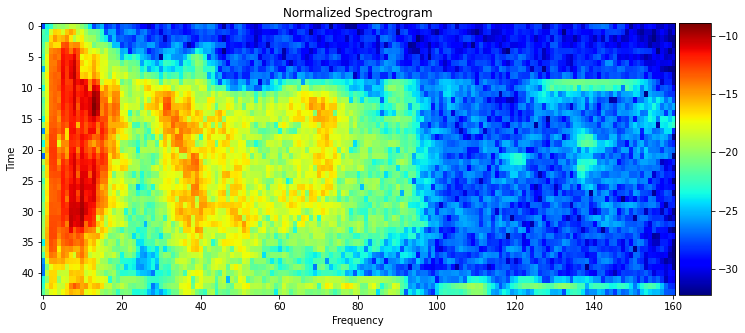

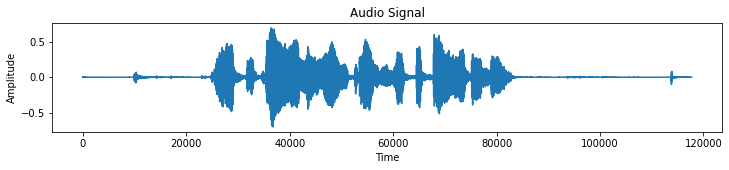

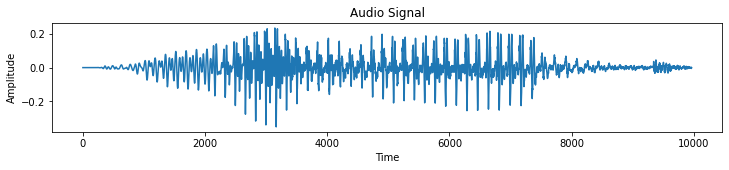

In [ ]:
def plot_raw(name):
    raw_audio = librosa.load("test/" + name)[0]
    plot_raw_audio(raw_audio, size=(12,2))

def plot_spect(name):
    plot_spectrogram_feature(spectrogram_from_file("test/" + name))

def plot_mfcc(name):
    (rate, sig) = wav.read("test/" + name)
    plot_mfcc_feature(mfcc(sig, rate, numcep=13))

plot_mfcc("speaker1_4.wav")
plot_mfcc("speaker1_2.wav")


plot_spect("speaker1_4.wav")
plot_spect("speaker1_2.wav")


plot_raw("speaker1_4.wav")
plot_raw("speaker1_2.wav")


In [ ]:
model = model_1(input_dim=13,
                units=5,
                activation='relu',
                output_dim=len(char_map)+1)
model.load_weights('models/RNN_model.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, None, 13)]        0         
_________________________________________________________________
rnn (GRU)                    (None, None, 5)           300       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 5)           20        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 223)         1338      
_________________________________________________________________
softmax (Activation)         (None, None, 223)         0         
Total params: 1,658
Trainable params: 1,648
Non-trainable params: 10
_________________________________________________________________
None


In [ ]:
index_map[0]=''

In [ ]:
from IPython.display import Audio
from IPython.display import Markdown, display

In [ ]:
predict(audio_gen,14, 'train', model)
_,_,_,raw_pred = predict_raw(audio_gen,14, 'train', model)
raw_pred_char = np.vstack([sorted(char_map.keys(), key=lambda k: char_map[k]) + ['BLANK'], raw_pred[0]])

Truth: ኢትዮጵያ ውስጥ የ ነበሩት ኤርትራውያን ም ተመሳሳይ እድል ነበራቸው
Predicted: 
wer: 42
